# Dissecting recurrent waves of pertussis across the boroughs of London

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import matplotlib.cm as cm
from utils import heatmap_snapshots
from utils import Matlab_CWT

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Pertussis cases
df_cases_weekly = pd.read_pickle('./data/Pertussis_cases_data_London_boroughs_1982_2013.pickle') 

In [4]:
# Vaccine data
df_vaccine_UK = pd.read_pickle('./data/UK_pertussis_vaccine_coverage_1965_2010.pickle')
df_vaccine_London = pd.read_pickle('./data/London_pertussis_vaccine_coverage_by_borough_1997_2016.pickle')

In [5]:
## London shape file
sf=gpd.read_file('./data/London.geojson')   
sf.index=sf['name']

In [6]:
df_population=pd.read_excel('./data/ons-mye-population-totals.xls',
                      sheet_name='MYE',skiprows=1,
                      index_col=2).dropna(axis=0,how='all')

## Figure 1

In [7]:
df_cases_monthly = df_cases_weekly.resample('M').sum()

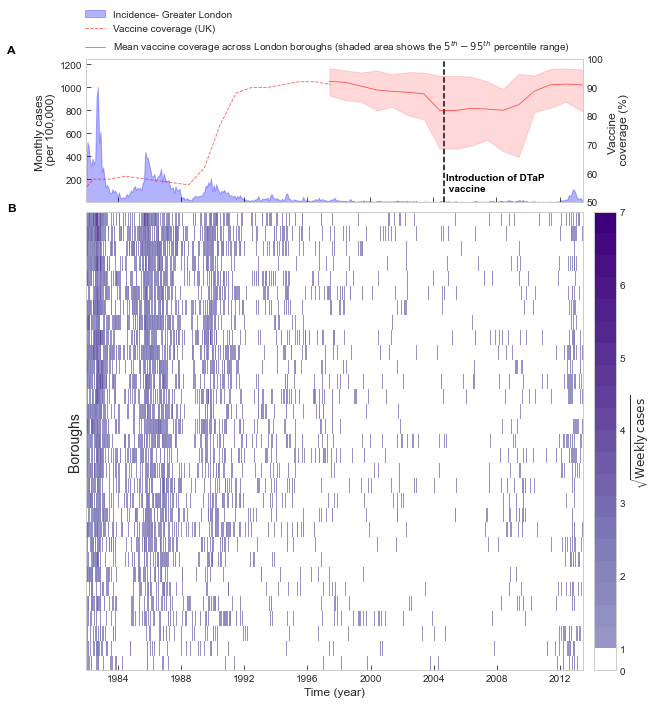

In [8]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(9.5,7.5*1.5))
grid = plt.GridSpec(64, 48,hspace=0,wspace=0)


ax2 = fig.add_subplot(grid[:15,:45 ])
ax3 = fig.add_subplot(grid[16:,:45 ])
ax_colorbar_incidence = fig.add_subplot(grid[16:, 46:])

  
GL_fill=ax2.fill_between(df_cases_monthly.index, 0, df_cases_monthly['Greater London'].values,
                 label='Incidence- Greater London',
                 color='blue',
                 alpha=0.3,
                 zorder=1.0)

ax2_vax = ax2.twinx()



idx1=pd.date_range(start='1965-7-1',end='1984-7-1',freq='365D')
idx2=pd.date_range(start='1988-7-1',end='2010-7-1',freq='365D')
idx_vaccine_UK=idx1.append(idx2)

 
vax_line, = ax2_vax.plot(idx_vaccine_UK[idx_vaccine_UK<'1998-1-1'],df_vaccine_UK.loc[:,df_vaccine_UK.columns<1998].values.squeeze(),
                         '--r',
                       #  color='red',
                         zorder=1,
                         alpha=0.6,
                         linewidth=0.9,
                         label='Vaccine coverage (UK)')


ax2_vax.fill_between(x=df_vaccine_London.index,y1=df_vaccine_London.quantile(0.975,axis=1),
                     y2=df_vaccine_London.quantile(0.025,axis=1),color='red',alpha=0.15)
mean_vax, = ax2_vax.plot(df_vaccine_London.mean(axis=1),color='red',alpha=0.6,linewidth=0.9,
             label='Mean vaccine coverage across London boroughs (shaded area shows the $5^{th}-95^{th}$ percentile range)')

ax2_vax.grid(False)
ax2_vax.set_ylabel('Vaccine \n coverage (%)',fontsize=12)
ax2_vax.set_ylim((50,100))



ax2.grid()

ax2.set_xlim(left=df_cases_weekly['1982'].index[0],right=pd.to_datetime('2013-6-30'))
ax2.set_ylim(bottom=1,top=1250)
legend1=plt.legend(handles=[GL_fill,vax_line,mean_vax],
                   fancybox=True,shadow=True,fontsize=10,ncol=1,bbox_to_anchor=(-0.02,1.4),loc=2)
#legend1.get_title().set_fontsize('10')
ax2.set_ylabel('Monthly cases \n (per 100,000)',fontsize=12)


ax2.text(x=pd.to_datetime('1977-1-1'),y=1300,s='A',fontsize=12,color='k',weight="bold")

ax2.axvline(pd.to_datetime('2004-9-1'),color='k',linestyle='--')
ax2.text(x=pd.to_datetime('2004-10-20'),y=100,s='Introduction of DTaP \n vaccine',fontsize=10,color='k',weight="bold")



right_edge = '2013-6-30'

borough_sorted_by_cum_cases=df_cases_weekly.drop(['City of London','Greater London'],axis=1)[:'2000'].sum(axis=0).sort_values().index.to_list()

cmap = plt.cm.Purples 
cmaplist = [cmap(i) for i in range(cmap.N//2,cmap.N)]
cmaplist[0] = (0, 0, 0, 0)

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, len(cmaplist))


bounds = np.insert(np.arange(1,7.3,0.3),0,0)
norm = mpl.colors.BoundaryNorm(bounds, len(cmaplist))

heatmap_incidence = ax3.pcolormesh(df_cases_weekly[borough_sorted_by_cum_cases][:right_edge].T.columns,
                            df_cases_weekly[borough_sorted_by_cum_cases][:right_edge].T.index,
                            np.sqrt(df_cases_weekly[borough_sorted_by_cum_cases][:right_edge].T.values),
                            cmap=cmap,norm=norm)

ax3.set_xlabel('Time (year)',fontsize=12)
unique_years= df_cases_weekly[borough_sorted_by_cum_cases][:right_edge].T.columns.year.unique()

ax3.set_yticks([])
ax3.set_ylabel('Boroughs',fontsize=14)
ax3.text(x=pd.to_datetime('1977-1-1'),y=31,s='B',fontsize=12,color='k',weight="bold")

cbar_incidence = plt.colorbar(heatmap_incidence,cax=ax_colorbar_incidence,ticks=[0,1,2,3,4,5,6,7])
cbar_incidence.ax.set_ylabel('$\sqrt{\mathrm{Weekly \, cases}}$',fontsize=12)

ax2.tick_params(direction='in',length=5,width=0.8)
ax3.tick_params(direction='in',length=5,width=0.8)
ax2.set_xticklabels([])



plt.show()

In [9]:
df_cases_annual = df_cases_weekly.resample('1Y').sum()
df_cases_annual_snapshot = df_cases_annual[df_cases_annual.index.year.isin([1982,1986,1990,2012])].T

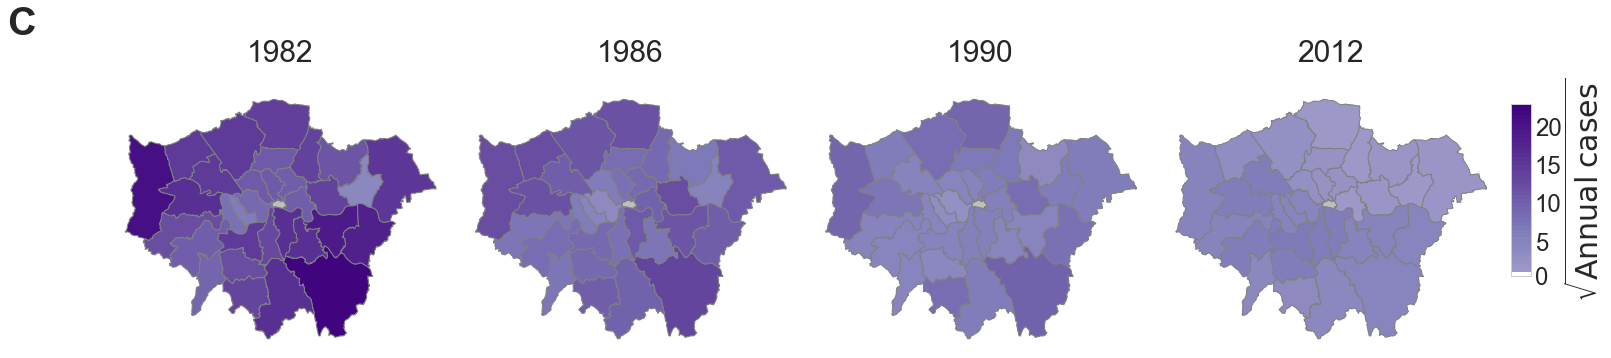

In [10]:
cmap = plt.cm.Purples 
cmaplist = [cmap(i) for i in range(cmap.N//2,cmap.N)]

cmaplist[0] = (0, 0, 0, 0)


cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, len(cmaplist))

bounds_cases = np.insert(np.arange(1,23.5,0.5),0,0)
norm_cases = mpl.colors.BoundaryNorm(bounds_cases, len(cmaplist))
df_sqrt_cases_annual_snapshot = np.sqrt(df_cases_annual_snapshot)
df_sqrt_cases_annual_snapshot.loc['City of London'] = [-1e5,-1e5,-1e5,-1e5]
fig,cbar=heatmap_snapshots(sf=sf,df_plot=df_sqrt_cases_annual_snapshot,
                      #vmin=0,vmax=14,
                      cmap=cmap,
                      norm=norm_cases,
                      cbar_label=r'$\sqrt{\mathrm{Annual \; cases}}$')
cbar.set_ticks(range(0,23,5))
axes=fig.get_axes()
for ax,year in zip(axes[:-1],[1982,1986,1990,2012]):
    ax.text(0.40,1.1,str(year),transform=ax.transAxes,fontsize=30)

axes[0].text(-0.3,1.2,'C',transform=axes[0].transAxes,fontsize=40,weight='bold')
plt.show()

## Figure 2

In [24]:
df_CWT_London,_,_ = Matlab_CWT(df_cases_weekly['Greater London'])
df_local_power_London =  np.abs(df_CWT_London.loc[0.5:10,'1982':'2013-7-1'])**2  
period_years=list(df_local_power_London.index)
ylim_right=8.22
ylim_left=1.0

In [27]:
cases_by_age_all=pd.read_csv('./data/noids.csv',index_col=0,na_values='NA')
cases_by_age_all.index.name='row'
cases_by_age_all.age.fillna(value=0,inplace=True)
cases_by_age_all.mos.fillna(value=0,inplace=True)
region='london'
cases_by_age=cases_by_age_all[cases_by_age_all.region==region].copy()
cases_by_age['date'].astype(str,copy=False)
cases_by_age.index=pd.to_datetime(cases_by_age.date,yearfirst=True)
cases_by_age.drop('date',inplace=True,axis=1)
cases_by_age=cases_by_age[cases_by_age.area!='City of London']
cases_by_age.area.replace('Westminster City of','Westminster',inplace=True)
cases_by_age.loc[cases_by_age['age']>0,'mos'] = 6
cases_by_age['age_months'] = cases_by_age.age * 12 + cases_by_age.mos 

In [28]:
df_cases_by_age = cases_by_age.groupby(['age_months','date']).count()['area'].unstack().fillna(0).T.resample('1Y').sum().T

series_mean_age_of_infection = pd.Series(index =df_cases_by_age.columns )
for week in df_cases_by_age.columns:
    series_mean_age_of_infection[week] = (df_cases_by_age[week]*df_cases_by_age.index).sum()/(df_cases_by_age[week].sum())
series_mean_age_of_infection = series_mean_age_of_infection/12


df_cases_by_age.loc[0] = df_cases_by_age.loc[np.arange(12)].sum()
df_cases_by_age.drop(np.arange(1,12),axis=0,inplace=True)
df_cases_by_age = df_cases_by_age / df_cases_by_age.sum()
df_cases_by_age.index = df_cases_by_age.index//12
df_cases_by_age = df_cases_by_age.loc[df_cases_by_age.index[::-1]]

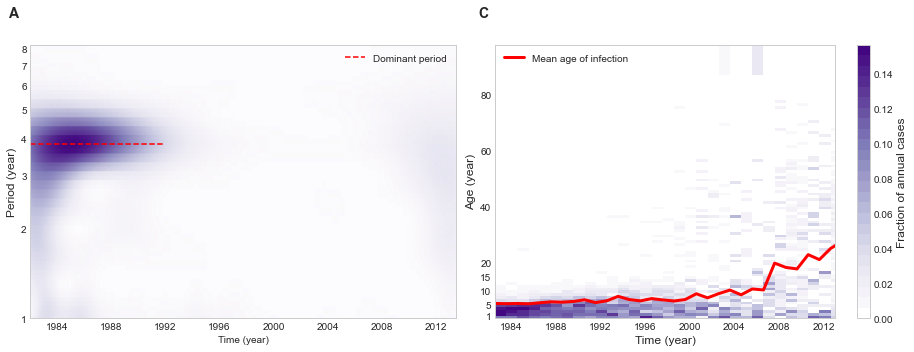

In [29]:
cmap = plt.cm.Purples 
cmaplist = [cmap(i) for i in range(0,cmap.N,10)]
cmaplist[0] = (0, 0, 0, 0)

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, len(cmaplist))



fig,[ax1,ax2] = plt.subplots(1,2,figsize=(6.5*2,2.5*2))



CWT_spec = ax1.pcolormesh(df_local_power_London.columns,np.log(period_years), df_local_power_London.values,
                          cmap='Purples',
                          shading='gouraud',
                          rasterized=True,
                          label=None)
ax1.plot(df_local_power_London.loc[:,'1982':'1992-1-1'].columns,
         np.log(df_local_power_London.loc[:,'1982':'1992-1-1'].idxmax().values),
         '--r',label='Dominant period')





ax1.set_ylim((np.log(ylim_left),np.log(ylim_right)))

ax1.set_ylabel('Period (year)',fontsize=12)

ytick_values=np.arange(1,9)
ytick_pos=np.log(ytick_values)
ax1.set_yticks(ytick_pos)
ax1.set_yticklabels(ytick_values)
ax1.set_xlabel('Time (year)')
ax1.legend()


age_heatmap = ax2.pcolormesh(df_cases_by_age.columns,df_cases_by_age.index,df_cases_by_age.values,cmap=cmap)
ax2.plot(series_mean_age_of_infection,color='red',label='Mean age of infection',linewidth=3)
ax2.set_xlim(right=cases_by_age['2013-6'].index[0])
ax2.set_yticks([1,5,10,15,20,40,60,80])
idx_xticks = pd.date_range(start='1983-6-1',end='2013-6-1',freq='365d')
ax2.set_xticks(idx_xticks[1::4]);
ax2.set_xticklabels(idx_xticks[1::4].year);



cbar=fig.colorbar(age_heatmap)

cbar.set_label('Fraction of annual cases',fontsize=12)

ax2.set_ylabel('Age (year)',fontsize=12)
ax2.legend(loc=2)
ax2.set_xlabel('Time (year)',fontsize=12)



ax1.text(x=-0.05,y=1.1,s='A',transform=ax1.transAxes,weight='bold',fontsize=14)
ax2.text(x=-0.05,y=1.1,s='C',transform=ax2.transAxes,weight='bold',fontsize=14)



plt.tight_layout()
plt.show()

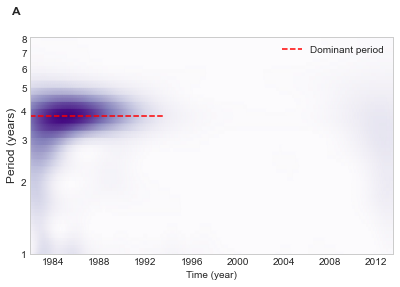

In [14]:
fig,ax1 = plt.subplots(1,1,figsize=(6.5,4))
CWT_spec = ax1.pcolormesh(df_local_power_London.columns,np.log(period_years), df_local_power_London.values,
                          cmap='Purples',
                          shading='gouraud',
                          rasterized=True,
                          label=None)
ax1.plot(df_local_power_London.loc[:,'1982':'1993-8'].columns,
         np.log(df_local_power_London.loc[:,'1982':'1993-8'].idxmax().values),
         '--r',label='Dominant period')


ax1.set_ylim((np.log(ylim_left),np.log(ylim_right)))

ax1.set_ylabel('Period (years)',fontsize=12)

ytick_values=np.arange(1,9)
#ytick_values=[1,2,4,8]
ytick_pos=np.log(ytick_values)
ax1.set_yticks(ytick_pos)
ax1.set_yticklabels(ytick_values)
ax1.set_xlabel('Time (year)')
ax1.legend()
ax1.text(x=-0.05,y=1.1,s='A',transform=ax1.transAxes,weight='bold',fontsize=12)

plt.show()